# GOAL: Model the relationship between a car's characteristics and the price.
#### Process will involve multiple regression models with cross validation.
#### Will evaluate models on how well they can predict the price of a car.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

In [2]:
cars = pd.read_csv('data/vehicles.csv')

In [3]:
# We want to see the columns on the data set to see what data we have
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# We can .describe() the dataset, check for the null count sum
print(cars.describe())
print(cars.isnull().sum())

                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


In [5]:
#Get rid of some outliers
lower_bound, upper_bound = cars['price'].quantile([0.03, 0.97])
cars = cars[(cars['price'] > lower_bound) & (cars['price'] < upper_bound)]
print(lower_bound,upper_bound)
# Drop rows where year,VIN, odometer, condition, or manufacturer missing
cars.dropna(subset=['year'], inplace=True)
cars.dropna(subset=['condition'], inplace=True)
cars.dropna(subset=['odometer'], inplace=True)
cars.dropna(subset=['manufacturer'], inplace=True)
cars.dropna(subset=['VIN'], inplace=True)
cars.dropna(subset=['type','title_status','transmission','drive','fuel','size','cylinders'], inplace=True)

0.0 50666.70000000042


C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


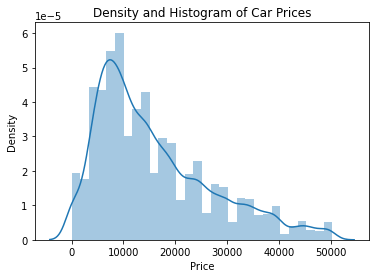

In [6]:
sns.distplot(cars['price'], hist=True, kde=True, bins=30)
plt.title('Density and Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

In [7]:
# Creates a few new features that may be relevant
current_year = pd.to_datetime('now').year
cars = cars[(cars['price'] > 1000)]
cars = cars[cars['year'] > 1990]
cars['car_age'] = current_year - cars['year']

# Scales numerical columns for accuracy improvement
scaler = StandardScaler()
cars[['odometer', 'car_age']] = scaler.fit_transform(cars[['odometer', 'car_age']])

# New feature of car age times the odometer
cars['age_odometer_interaction'] = cars['car_age'] * cars['odometer']

cars.drop_duplicates(inplace=True)
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,car_age,age_odometer_interaction
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,0.690563,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al,1.792123,1.237574
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,-0.012712,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al,3.141428,-0.039934
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,-0.868605,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al,0.635577,-0.552065
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,0.833315,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al,0.057303,0.047752
355,7315110575,birmingham,9400,2008.0,mercedes-benz,benz c350,good,6 cylinders,gas,0.285671,clean,automatic,WDDGF56X68F140907,rwd,full-size,sedan,silver,al,0.635577,0.181566


In [8]:
# Drops seemingly unnecessary columns
cars = cars.drop(['region', 'id', 'VIN','state','year','model'], axis=1)

In [9]:
# Fills nulls first with unknown
for col in ['manufacturer','type','paint_color',
'title_status','transmission','drive','fuel','size','condition','cylinders']:
    cars[col] = cars[col].fillna('unknown')
# One hot encode the manufacturer column for the categorical columns
cars = pd.get_dummies(cars, columns=['type','transmission','drive','fuel','size','cylinders'], drop_first=True)

In [10]:
# Turns nominal categorical data into numerical data
label_encoder = LabelEncoder()
for col in ['condition','title_status','manufacturer','paint_color']:
    cars[col] = label_encoder.fit_transform(cars[col])
# cars = cars.drop(['size_mid-size','size_sub-compact'], axis=1)    
# New features that may improve accuracy
cars['title_status_age'] = cars['car_age'] * cars['title_status']
cars['manufacturer_age'] = cars['car_age'] * cars['manufacturer']
cars['manufacturer_odometer'] = cars['odometer'] * cars['manufacturer']
cars['title_satus_odometer'] = cars['odometer'] * cars['title_status']
cars.head()


,price,manufacturer,condition,odometer,title_status,paint_color,car_age,age_odometer_interaction,type_bus,type_convertible,...,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,title_status_age,manufacturer_age,manufacturer_odometer,title_satus_odometer
215,4000,36,0,0.690563,0,1,1.792123,1.237574,0,0,...,0,1,0,0,0,0,0.0,64.516440,24.860262,0.0
219,2500,4,1,-0.012712,0,11,3.141428,-0.039934,0,0,...,0,0,0,1,0,0,0.0,12.565711,-0.050848,-0.0
268,9000,23,0,-0.868605,0,11,0.635577,-0.552065,0,1,...,0,1,0,0,0,0,0.0,14.618262,-19.977904,-0.0
337,8950,11,0,0.833315,0,11,0.057303,0.047752,0,0,...,0,0,0,1,0,0,0.0,0.630336,9.166461,0.0
355,9400,24,2,0.285671,0,9,0.635577,0.181566,0,0,...,0,0,0,1,0,0,0.0,15.253839,6.856105,0.0


In [11]:
# Split the data into test and train
X = cars.drop('price', axis=1) 
y = cars['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
# Fit only on training set, but scale on both
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Initialize PCA, reducing the dataset to 50 components
pca = PCA(n_components=41)

# Fit and transform the scaled training data to reduced number of features
# Then transform Scaled test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check how much variance is we have captured
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_)}")

Explained variance ratio: 1.0


In [14]:
# Linear Regression Model
lin_reg = LinearRegression().fit(X_train_pca, y_train)
y_pred_lin_reg = lin_reg.predict(X_test_pca)
test_mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
print(f"Test MSE for Linear Regression: {test_mse_lin_reg}")
test_mae_lin_reg = mean_absolute_error(y_test,y_pred_lin_reg)
print(f"Test MAE: {test_mae_lin_reg}")

Test MSE for Linear Regression: 29539096.850978903
Test MAE: 4021.8344301067473


In [15]:
# Hyperparameter tuning for Ridge Regression
param_grid = {'alpha': [0.1, 1, 10]}
ridge_reg = Ridge()
grid_search_ridge = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(X_train_pca, y_train)

print(f"Best parameters for Ridge: {grid_search_ridge.best_params_}")
print(f"Best Cross-validation MSE for Ridge: {grid_search_ridge.best_score_}")

best_model = grid_search_ridge.best_estimator_

# Transform the test set with the same transformations as the training set
X_test_pca = pca.transform(X_test_scaled)

# Predict and evaluate
y_pred = best_model.predict(X_test_pca)
test_mse = mean_squared_error(y_test, y_pred)
test_mae_ridge = mean_absolute_error(y_test,y_pred)
print(f"Test MAE: {test_mae_ridge}")
print(f"Test MSE: {test_mse}")

Best parameters for Ridge: {'alpha': 10}
Best Cross-validation MSE for Ridge: -29885994.098404508
Test MAE: 4022.369528213593
Test MSE: 29544770.417483035


In [16]:
# Define a range of alpha values for Lasso
param_grid_lasso = {'alpha': [0.1, 1, 10]}

# Initialize the Lasso model and Grid searchCV 
lasso = Lasso(max_iter=10000, random_state=42)
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search_lasso.fit(X_train_pca, y_train)

# Print the best parameters and the corresponding MSE
print(f"Best parameters for Ridge: {grid_search_lasso.best_params_}")
print(f"Best Cross-Validation MSE for Lasso: {grid_search_lasso.best_score_}")

Best parameters for Ridge: {'alpha': 1}
Best Cross-Validation MSE for Lasso: -29886222.362197913


In [17]:
# Use the best model from the grid search
best_model_lasso = grid_search_lasso.best_estimator_

# Predict on the test set using PCA-transformed features
y_pred_lasso = best_model_lasso.predict(X_test_pca)

# Calculate and print the MSE for the test set
mae = mean_absolute_error(y_test, y_pred_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 4022.1150061691433
Mean Squared Error: 29543043.67459667


In [33]:
# Model-Based Feature Selection
selector = SelectFromModel(Lasso(alpha=.1))
selector.fit(X_train_pca, y_train)
X_selected_train = selector.transform(X_train_pca)
X_selected_test = selector.transform(X_test_pca)

# Using the selected features for Lasso
lasso = Lasso(alpha=.1).fit(X_selected_train, y_train)
y_pred = lasso.predict(X_selected_test)
print("MAE:", mean_absolute_error(y_test, y_pred))

MAE: 4022.115006169144


In [31]:
1-( mean_absolute_error(y_test, y_pred)/cars['price'].mean())

0.7546465713210585

In [32]:
feature_importances = list(zip(X_train.columns, lasso.coef_))

# Sorting the features by absolute value of their coefficients
sorted_features = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)

# Printing sorted features from most to least important
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

title_satus_odometer: 5234.656161621228
condition: -4041.623388483861
cylinders_8 cylinders: -3641.9722106625654
cylinders_other: 3591.1951817173485
title_status_age: -2571.103641426665
type_convertible: -2122.4190587718613
manufacturer: 1814.86688686776
cylinders_4 cylinders: 1773.6751763213465
drive_fwd: 1596.1928634796193
title_status: -1373.4418812618885
cylinders_12 cylinders: -1236.9135081520774
type_mini-van: -1097.7900768152099
manufacturer_odometer: 1089.2458430787392
fuel_hybrid: 1035.3526350782292
transmission_manual: 983.2937795683795
drive_rwd: -982.1292899197608
cylinders_3 cylinders: -918.7239848469479
size_mid-size: 806.5326454948399
cylinders_6 cylinders: -779.5103971705113
type_sedan: 748.5015575699737
type_hatchback: 728.2980027734964
age_odometer_interaction: -636.095998236346
fuel_electric: 572.5899203510941
type_offroad: 514.4051103943749
transmission_other: 488.4803641869449
type_pickup: 465.28224070729465
fuel_gas: -422.75717791297717
manufacturer_age: -358.1028

In [90]:
from sklearn.model_selection import GroupKFold
groups = cars['manufacturer'].factorize()[0]
means=[]
best_mae = float('inf')

group_kfold = GroupKFold(n_splits=8)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=41).fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Explained variance ratio for this fold: {np.sum(pca.explained_variance_ratio_)}")
    # Define a range of alpha values for Lasso
    param_grid_lasso = {'alpha': [0.1, 1, 10]}

    # Initialize the Lasso model and Grid searchCV 
    lasso = Lasso(max_iter=10000, random_state=42)
    grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Fit the model
    grid_search_lasso.fit(X_train_pca, y_train)

    # Print the best parameters and the corresponding MSE
    print(f"Best parameters for Lasso: {grid_search_lasso.best_params_}")
    print(f"Best Cross-Validation MSE for Lasso: {grid_search_lasso.best_score_}")
    best_alpha = grid_search_lasso.best_params_['alpha']
    # Feature selection and model training
    selector = SelectFromModel(Lasso(alpha=best_alpha)).fit(X_train_pca, y_train)
    X_selected_train = selector.transform(X_train_pca)
    X_selected_test = selector.transform(X_test_pca)
    model = Lasso(alpha=best_alpha).fit(X_selected_train, y_train)
    y_pred = model.predict(X_selected_test)
    mae = int(mean_absolute_error(y_test, y_pred))
    print(f"MAE for this fold: {mae}")
    if mae < best_mae:
        best_mae = mae
        X_train_best, X_test_best = X.iloc[train_index], X.iloc[test_index]
        y_train_best, y_test_best = y.iloc[train_index], y.iloc[test_index]
        
    means.append(mean_absolute_error(y_test, y_pred))
print(np.mean(means))

Explained variance ratio for this fold: 1.0000000000000002
Best parameters for Lasso: {'alpha': 10}
Best Cross-Validation MSE for Lasso: -28042680.93412627
MAE for this fold: 4886
Explained variance ratio for this fold: 0.9999999999999999
Best parameters for Lasso: {'alpha': 1}
Best Cross-Validation MSE for Lasso: -29565304.967261232
MAE for this fold: 4443
Explained variance ratio for this fold: 0.9999999999999998
Best parameters for Lasso: {'alpha': 1}
Best Cross-Validation MSE for Lasso: -30620022.691280283
MAE for this fold: 3862
Explained variance ratio for this fold: 0.9999999999999999
Best parameters for Lasso: {'alpha': 0.1}
Best Cross-Validation MSE for Lasso: -30546187.239656
MAE for this fold: 3778
Explained variance ratio for this fold: 1.0
Best parameters for Lasso: {'alpha': 1}
Best Cross-Validation MSE for Lasso: -31237832.94702403
MAE for this fold: 3604
Explained variance ratio for this fold: 0.9999999999999998
Best parameters for Lasso: {'alpha': 1}
Best Cross-Validat

In [108]:
original_feature_names = X_train.columns.tolist()
# Standardize features
scaler = StandardScaler().fit(X_train_best)
X_train_scaled = scaler.transform(X_train_best)
X_test_scaled = scaler.transform(X_test_best)

# Define a range of alpha values for Lasso
param_grid_lasso = {'alpha': [0.1, 1, 10]}

# Initialize the Lasso model and Grid searchCV 
lasso = Lasso(max_iter=10000, random_state=42)
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search_lasso.fit(X_train_scaled, y_train_best)

# Print the best parameters and the corresponding MSE
print(f"Best parameters for Lasso: {grid_search_lasso.best_params_}")
print(f"Best Cross-Validation MSE for Lasso: {grid_search_lasso.best_score_}")
best_alpha = grid_search_lasso.best_params_['alpha']

# Feature selection and model training
selector = SelectFromModel(Lasso(alpha=best_alpha)).fit(X_train_scaled, y_train_best)
X_selected_train = selector.transform(X_train_scaled)
X_selected_test = selector.transform(X_test_scaled)

# We want the names out of the features for usefulness ranking
selected_features_mask = selector.get_support()
selected_feature_names = [original_feature_names[i] for i in range(len(original_feature_names)) if selected_features_mask[i]]

model = Lasso(alpha=best_alpha).fit(X_selected_train, y_train_best)
y_pred = model.predict(X_selected_test)
mae = int(mean_absolute_error(y_test_best, y_pred))
mae
print(1-(mae/cars['price'].mean()))

Best parameters for Lasso: {'alpha': 1}
Best Cross-Validation MSE for Lasso: -31235843.82385851
0.7801382155032857


In [105]:
# Sorting the features by absolute value of their coefficients
feature_importances = [(name, coef) for name, coef in zip(selected_feature_names, best_model.coef_)]
sorted_features = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)

# Printing sorted features from most to least important
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

title_satus_odometer: 5361.960327312838
cylinders_8 cylinders: -4663.257438845671
condition: -3958.327370321809
cylinders_other: 3084.3532278125085
type_convertible: 2170.1688301889503
manufacturer: 2150.398721191396
drive_fwd: 1768.2247442533617
cylinders_5 cylinders: -1687.3747227963863
title_status_age: -1476.9003786951198
cylinders_12 cylinders: -1421.0184495449141
title_status: 1375.187218916638
type_mini-van: 1123.8763171442736
fuel_gas: 1047.258238235884
cylinders_3 cylinders: -1020.3424393605959
transmission_manual: 999.5321407265504
drive_rwd: -952.4734038183153
manufacturer_odometer: 935.5606701878539
cylinders_4 cylinders: -854.7964420795041
type_sedan: 835.8439225502988
type_bus: -831.9880970953848
size_mid-size: -803.908884737912
cylinders_6 cylinders: 681.2015088489337
fuel_electric: -605.1336077214851
fuel_other: -565.9550182493406
fuel_hybrid: 515.274682275671
age_odometer_interaction: -483.26989725459094
transmission_other: 455.825761611723
type_offroad: 400.8945590906